# <center> Python Bokeh
<img src="https://github.com/Ray800413/Visualize_with_Bokeh/blob/master/image/bokeh.png?raw=true" style="width: 600px;">

### 1. Introduction

As a GIS programmer, I often find that I have to dedicate my time learning data visualization libraries in order to create maps. There are lots of visualization libaries out there in Python community, such as `Matplotlib` and `Folium`, can help us to do. However, most of these libaries do not provide interactivity. This is problematic as people nowadays expect they can "interact" with maps on screen, such as constantly zoom in/out and get feature informaion through hovering on them. Luckily, there is a Python libarary called `Bokeh` that is able to create such interactive maps painlessly.  

This Jupyter Notebook is designed for people who are interested in creaing maps using `Bokeh`. Readers are assumed to already be familiar with `Geopandas`. The purpose of this notebook is to help you learn `Bokeh` quickly through several examples. You are encouraged to read more at `Bokeh` [official website](https://docs.bokeh.org/en/latest/index.html) if you want to learn it from scratch. 

### 2. Bokeh brief introduction

`Bokeh` is an interactive visualization library for modern web browsers. It provides elegant, concise construction of versatile graphics, and affords high-performance interactivity over large or streaming datasets. 

To offer both simplicity and the powerful and flexible features needed for advanced customizations, `Bokeh` exposes two interface levels to users:

- `bokeh.models`: A *low-level* interface that provides the most flexibility to application developers.
- `bokeh.plotting`: A *high-level* interface centered around composing visual glyphs. 

### 3. Examples

#### 3.1 Basic plotting
We first look at a simple example to understand the basic usage of `Bokeh`. 

In [1]:
# Import necessary functionalities from bokeh
# You will use these functionalities nearly every time whenever you plot with bokeh
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

- `bokeh.plotting.figure`: Create a new Figure for plotting
- `bokeh.io.output_notebook`: Configure the default output state to generate output in notebook cells when `bokeh.io.show()` is called.
- `bokeh.io.show`: Immediately display a Bokeh object or application. 

In [2]:
# Initialize the plot and give it a title, and the height and width
p = figure(title = "Test", plot_height = 400, plot_width = 400)
# In Bokeh, drawing geometry is always done using list(s) of x and y
# Create a list of x-coordinates and y-coordinates
x_coords = [0, 1, 2, 3, 4]
y_coords = [5, 4, 1, 2, 0]

# Plot the points
p.circle(x= x_coords, y= y_coords, size = 10, color = "red")

# Show the figure
show(p)

#### 3.2 Create a simple interactive point map using Bokeh and Geopandas

`Bokeh` has started adding support for working with geographic data. In the following examples, we will use shapefiles to create several maps.

Creating an interactive `Bokeh` map from shapefiles contains typically following steps: 
1. Read a shapefile into `Geopandas` geodataframe.
2. Calculate the x and y coordinates of the geometries into separate columns.
3. Convert the geodataframe into a `Bokeh` datasource.
4. Plot the x and y coordinates as points, lines or polygons (which are in `Bokeh` words: **circle**, **multi_line**, and **patches**)

*Note*: You can skip step 2 and 3 by implementing `Bokeh`'s `GeoJSONDataSource`. This data structure can be used almost seamlessly in place of `Bokeh`'s `ColumnDataSource`.

##### 3.2.1 Plot the points

In [3]:
# Import modules
import geopandas as gpd
from bokeh.models import ColumnDataSource

- `bokeh.models.ColumnDataSource`: A fundamental data structure of Bokeh. Maps names of columns to sequences or arrays. 

In [4]:
# 1. Read the shapefile
point_gdf = gpd.read_file("data/L5_data/schools_tartu.shp")
point_gdf = point_gdf.drop(['X', 'y'], axis = 1)
point_gdf.head(1)

,id,name,Aadress,geometry
0,13376,Aakre Lasteaed-Algkool,"Valga maakond, Puka vald, Aakre küla, Mõisa te...",POINT (629862.000 6441779.000)


In [5]:
# 2. Extract out x and y values from the point shapefile
def getPointCoords(row, geom, coord_type):
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [6]:
# Using pandas apply function to extract out x and y
point_gdf['x'] = point_gdf.apply(getPointCoords, 
                              geom = "geometry", 
                              coord_type = 'x', axis=1)
point_gdf['y'] = point_gdf.apply(getPointCoords, 
                              geom = "geometry", 
                              coord_type = 'y', axis=1)
point_gdf.head(1)

,id,name,Aadress,geometry,x,y
0,13376,Aakre Lasteaed-Algkool,"Valga maakond, Puka vald, Aakre küla, Mõisa te...",POINT (629862.000 6441779.000),629862.0,6441779.0


In [7]:
# 3. Convert the dataframe into a format that Bokeh can understand
# The format is ColumnDataSource

# Drop the Shapely geometry-objects in that ColumnDataSource does not understand it
point_gdf = point_gdf.drop("geometry", axis=1)
psource = ColumnDataSource(point_gdf)

In [8]:
# 4. Plot it out
p = figure(title = "A map of school location points", 
           plot_height = 400, plot_width = 400)

# Add the points to the map from ColumnDataSource object
# x/y denotes the x/y-axis coordinates for the center of the markers
p.circle(x = 'x', y = 'y', source = psource, color = 'red', size = 10)

show(p)

##### 3.2.2 Add the interactivity

In `Bokeh`, there are specific set of plot tools that you can add to the plot. 

In [9]:
# Import tool
from bokeh.models import HoverTool

In [10]:
# Initialize the tool
my_hover = HoverTool()
# Tell the Hovertool that what information it should show to us.
my_hover.tooltips = [("Name of the school", "@name")]

**_Note_**: `tooltip `should be defined with a list of tuples where the first item is the name or label for the information that will be shown, and the second item is the *column-name* where that information should be read in the data. The @ character in front of the column-name is important as it tells that the information should be taken from a column.

In [11]:
# Add the tool to the plot
p.add_tools(my_hover)
show(p)

#### 3.3 Create a simple interactive polygon map with points using Bokeh and Geopandas

In [12]:
# 1. Read the shapefiles
point_gdf = gpd.read_file("data/L5_data/schools_tartu.shp")
polygon_gdf = gpd.read_file("data/L5_data/population_square_km.shp")
polygon_gdf.head(1)

,STAMP_CRE,Population,geometry
0,1899-12-30,0,"POLYGON ((625000.000 6433000.000, 624000.000 6..."


We first need to make sure two data sources are in the same coordinate system

In [13]:
# 2. Make sure they are in the same coordinate reference
point_CRS = point_gdf.crs
polygon_CRS = polygon_gdf.crs

if point_CRS == polygon_CRS:
    pass
elif point_CRS != polygon_CRS:
    point_gdf = point_gdf.to_crs("EPSG:{}".format(CRS.to_epsg()))

In [14]:
# 3. Extract out x and y values from the point shapefile
def getPointCoords(row, geom, coord_type):
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [15]:
# Run the funciton to extract x and y from the point shapefile
point_gdf['x'] = point_gdf.apply(getPointCoords, 
                              geom = "geometry", 
                              coord_type = 'x', axis=1)
point_gdf['y'] = point_gdf.apply(getPointCoords, 
                              geom = "geometry", 
                              coord_type = 'y', axis=1)

In [16]:
# 4. Extract out x and y values from the polygon shapefile
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates of edges of a Polygon exterior"""
    # Parse the exterior of the coordinate
    exterior = row[geom].exterior
    
    if coord_type == 'x':
        return list(exterior.coords.xy[0])
    elif coord_type == 'y':
        return list(exterior.coords.xy[1])

In [17]:
# Run the funciton to extract x and y from the polygon shapefile
polygon_gdf['x'] = polygon_gdf.apply(getPolyCoords, geom='geometry', 
                                     coord_type='x', axis=1)
polygon_gdf['y'] = polygon_gdf.apply(getPolyCoords, geom='geometry',
                                     coord_type='y', axis=1)

In [18]:
# 5. Convert the geodataframes to ColumnDataSource
point_gdf = point_gdf.drop("geometry", axis=1)
point_source = ColumnDataSource(point_gdf)

polygon_gdf = polygon_gdf.drop("geometry", axis=1)
polygon_source = ColumnDataSource(polygon_gdf)

In [19]:
# 6. Define the color palette to classify the polygons
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper

# Create the color mapper
color_mapper = LogColorMapper(palette = palette)

- `bokeh.palettes` provide a collection of palettes for color mapping. This module contains the following sets of palettes:
    1. All *Color Brewer* palettes
    2. Categorical *D3* palettes
    3. The *Matplotlib* palettes Magma, Inferno, Plasma, and Viridis
    4. Palettes designed for color-deficient usability
    
    
- `bokeh.models.LogColorMapper` maps numbers in a range into a sequence of colors on a natural logarithm scale

In [20]:
# 7. Add the hover tools
# Initialize the hover tools
point_hover = HoverTool()
polygon_hover = HoverTool()

# Set names to the hover tools
point_hover.names = ["point"]
polygon_hover.names = ["polygon"]

# Tell the Hovertool that what information it should show to us.
point_hover.tooltips = [("Name of the school", "@name")]
polygon_hover.tooltips = [("Population Density", "@Population")]

- If set the name to a `Hovertools`, only renderers that have a matching value for their "name" attribute will be used.

In [21]:
# 8. Add the tiled basemap
from bokeh.tile_providers import Vendors, get_provider

# Get the provider tile
tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

- `bokeh.tile_providers`: provides pre-rendered tile sources for common third party tile services.
- `bokeh.tile.get_provider`: Use this function to retrieve an instance of a perdefined tile provider. 
- `bokeh.tile.Vendors`: Name of the tile provider to supply.

In [22]:
# Initialize the figure
p = figure(title = "Polygons with Points", 
           plot_height = 400, plot_width = 400)

# Deactivate grid line and axes
p.xgrid.visible = False 
p.ygrid.visible = False
p.axis.visible = False

# Add the tile
p.add_tile(tile_provider)

# Plot the polygons
p.patches('x', 'y', source = polygon_source, 
          fill_color = {'field':'Population', 
                        'transform': color_mapper}, 
          fill_alpha = 1.0, line_color = None, line_width = 0.85, 
          name = "polygon")

# Add the points on top of the polygon
p.circle('x', 'y', source = point_source, color = 'yellow', name = "point")

# Add the hover tool
p.add_tools(point_hover)
p.add_tools(polygon_hover)

show(p)

#### 3.4 Visualize fields in a given tile

The shapefile we are going to visualize is one of the deliverables from the **Everyfield** project led by Professor Eric Shook at University of Minnesota. This shapefile contains more than eighty thousands features and these features represents fields in given tile in Minnesota. 

We will create two maps using two different methods. The first method is using `Geopandas` built-in function and the other is using `Bokeh`. You can compare the differences between the two and think which one is suitable  

##### 3.4.1 Using `Geopandas` built-in plot function

In [23]:
# Import modules
import geopandas as gpd
import contextily as ctx
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
# Load the filed shapefile into GeoDataFrame
field_gdf = gpd.read_file("data/TQT_nir_seg_map_v5/TQT_nir_seg_map_v5.shp")

Here, we use `plt.subplots` class to create a figure with a set of subplots (axes objects). By doing so, you can manipulate your figure and axes much easier. 

<ipython-input-25-fd7b57ee6a5e>:11: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.CartoDB.DarkMatterNoLabels)


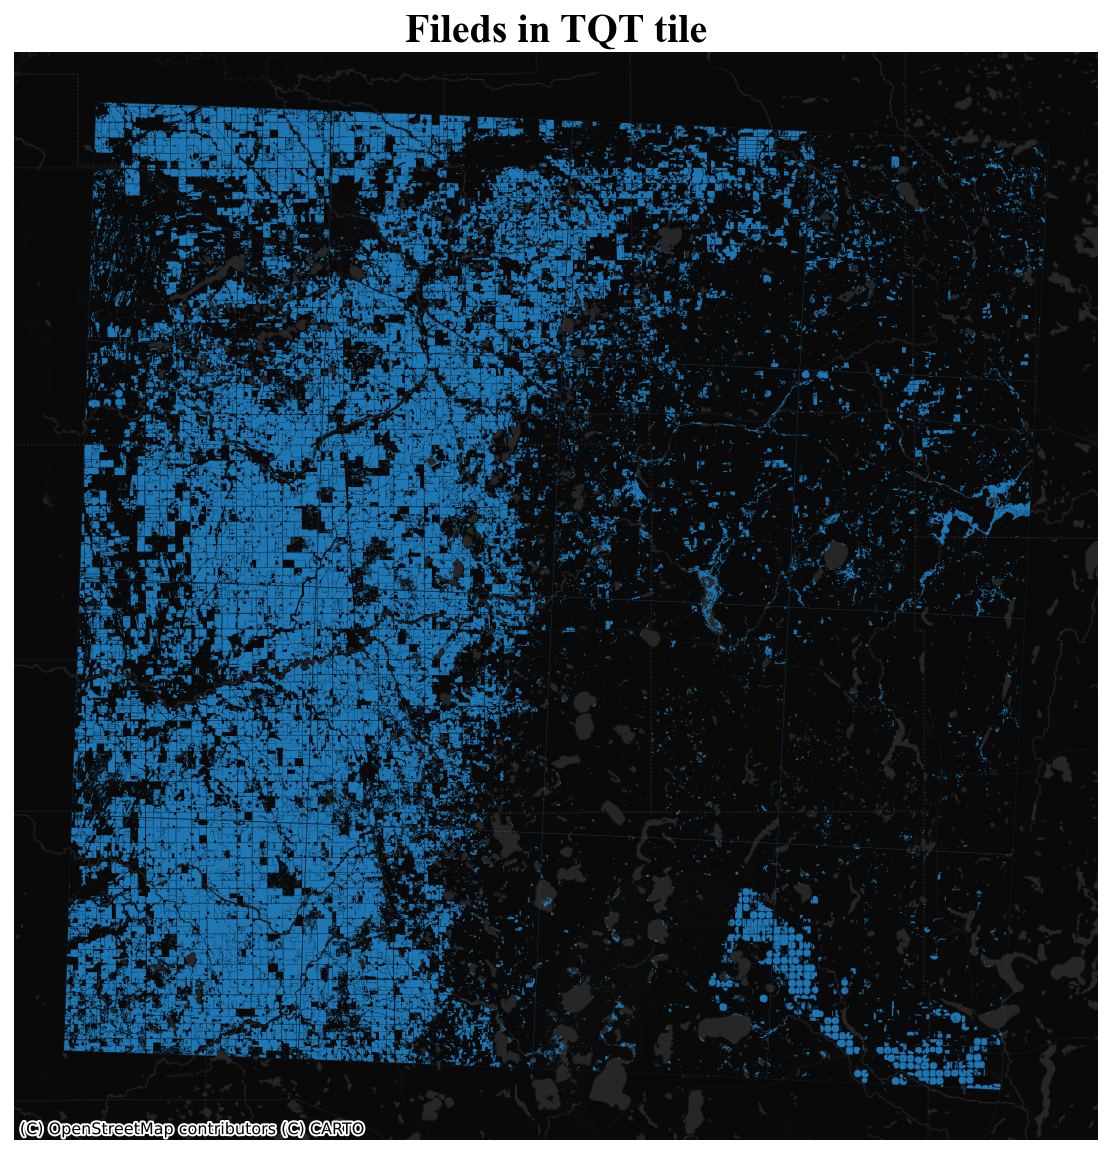

In [25]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(14, 10))

# Convert the coordinate system to web mercator to fit contextily basemap
field_gdf = field_gdf.to_crs("EPSG:3857")

# Plot the field polygons to the figure
field_gdf.plot(ax=ax, legend = False)

# Add base map under the feature layer
ctx.add_basemap(ax, url=ctx.providers.CartoDB.DarkMatterNoLabels)

# Deactivate the axis
ax.axis("off")
ax.set_title("Fileds in TQT tile", 
             fontdict={'fontsize': '20', 'fontweight': '5'}, 
             fontname="Times New Roman")

plt.show()

##### 3.4.2 Using `Geopandas` with `Bokeh`

In [26]:
# Import modules
from bokeh.plotting import figure, output_notebook
from bokeh.io import show
from bokeh.models import GeoJSONDataSource, HoverTool

output_notebook()

Loading BokehJS ...

- `bokeh.models.GeoJSONDataSource` makes it much easier to work and plot data from GeoDataFrame. You no longer need to extract x and y from geometry columns and convert geodataframes into `Bokeh` readable data structure: columndatasource. 

In [27]:
# 1. convert geodataframe to geojson representation
geosource = GeoJSONDataSource(geojson = field_gdf.to_json())

In [28]:
# 2. Find the range of x and y
xrange = (min(field_gdf.bounds[["minx", "maxx"]].values.flatten()),
          max(field_gdf.bounds[["minx", "maxx"]].values.flatten()))
yrange = (min(field_gdf.bounds[["miny", "maxy"]].values.flatten()),
          max(field_gdf.bounds[["miny", "maxy"]].values.flatten()))

In [29]:
# 3. Add a hover tool
field_hover = HoverTool()
field_hover.tooltips = [("Raster Value", "@raster_val")]

In [30]:
# Initialize a figure object
p = figure(title = "Fileds in TQT tile",
           plot_height = 600 , plot_width = 600, 
           x_range = xrange, y_range = yrange,
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, zoom_in, zoom_out, box_zoom, reset")

# Style the title
p.title.text_font = 'times'
p.title.text_font_style = 'bold'
p.title.text_font_size = '14pt'
p.title.align = 'center'


# Deactivate grid line and axis
p.xgrid.visible = False 
p.ygrid.visible = False
p.axis.visible = False

# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = '#1f77b4',
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Add the hover tool
p.add_tools(field_hover)

show(p)

##### 3.4.3 Note
Try to use the zoom tool. Did you find anything?

Yes, the rendering speed is pretty slow when you change the zoom level. This is because there are large numbers of polygons in this dataset. This is one of the common downside of using `Bokeh` to visualize large datasets. `Boekh` provides some solution to improve such situation.  
1. **Enable WebGL** : WebGL is a JavaScript API that allows rendering content in the browser via the Graphics Processing Unit (GPU), without the need for plugins. WebGL is standardized and available in all modern browsers. To enable WebGL, set the plots' `output_backend` property to "webgl"
```python
p = figure(output_backend = "webgl")
```
However, only a subset of Bokeh's objects are capable of rendering in WebGL. Currently supported are the circle and line glyphs, and most markers supported by `scatter()`.


2. **Controlling Level of Detail**: In order to accommodate large-ish data sizes, `Bokeh` plots offer "Level of Detail" (LOD) capability in the client. The basic idea is that during interactive operations, the plot only draws some small fraction of data points. Four properties that control LOD behavior:
```python
lod_factor, lod_interval, lod_threshold, lod_timeout
```
However, this only works on point data. 

While above solutions are not applicable in polygon(patche) cases, you should keep these in mind. These will come in handy when you want to plot large point or line datasets. 

### 4. Conclusion
In this tutorial, we walked through the basic introduction of Python `Bokeh` and several examples of using it with `Geopandas` to create interactive maps. This tutorial only scratchs the surface of `Bokeh` and you are encouraged to explore more possibilities by yourself.

Thank you for reading this tutorial. If you have trouble reproducing the steps, or if you find any problem, let me know by sending email to this address lin00297@umn.edu